In [ ]:
from google.colab import drive

drive.mount('/content/drive')

folder_dir = '/content/drive/My Drive/Colab Notebooks/'

Mounted at /content/drive


In [ ]:
from jax import jit,grad,vmap,device_put,random
import jax.numpy as jnp
import numpy as np
import pandas as pd
from functools import partial
import time
from sklearn.model_selection import train_test_split

# Setup datasets

df_kminst_train = pd.read_csv(folder_dir+'k49_train.csv')
df_kminst_test = pd.read_csv(folder_dir+'k49_test.csv')

df_kminst_train = df_kminst_train.iloc[: , 1:]
df_kminst_test = df_kminst_test.iloc[: , 1:]

y_train = df_kminst_train['label'].to_numpy()
y_test = df_kminst_test['label'].to_numpy()

X_train = df_kminst_train.loc[:, df_kminst_train.columns != 'label'].to_numpy()
X_test = df_kminst_test.loc[:, df_kminst_test.columns != 'label'].to_numpy()

print('X_train:', X_train.shape,'Y_train:', y_train.shape,'X_test:', X_test.shape,'Y_test:', y_test.shape) 

X_train: (232365, 784) Y_train: (232365,) X_test: (38547, 784) Y_test: (38547,)


In [ ]:
# Logistic regression with JAX class

class JaxReg:
    """
    Logistic regression classifier with GPU acceleration support through Google's JAX. The point of this class is fitting speed: I want this 
    to fit a model for very large datasets (k49 in particular) as quickly as possible!

    - jit compilation utilized in sigma and loss methods (strongest in sigma due to matrix mult.). We need to 'partial' the 
      jit function because it is used within a class.

    - jax.numpy (jnp) operations are JAX implementations of numpy functions. 

    - jax.grad used as the gradient function. Returns gradient with respect to first parameter.

    - jax.vmap is used to 'vectorize' the jax.grad function. Used to compute gradient of batch elements at once, in parallel.
    """

    def __init__(self, learning_rate=.001, num_epochs = 50, size_batch = 20):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.size_batch = size_batch     
        
    def fit(self, data, y):
        self.K = max(y)+1 
        ones = jnp.ones((data.shape[0],1))
        X = jnp.concatenate((ones, data), axis = 1) 
        W = jnp.zeros((jnp.shape(X)[1], max(y)+1))

        self.coeff = self.mb_gd(W, X, y)

    # New mini-batch gradient descent function (because jitted functions require arrays which do not change shape)
    def mb_gd(self, W, X, y):
        num_epochs = self.num_epochs
        size_batch = self.size_batch
        eta = self.learning_rate
        N = X.shape[0]
      
        # Define the gradient function using jit, vmap, and the jax's own gradient function, grad.
        # vmap is especially useful for mini-batch GD since we compute all gradients of the batch at once, in parallel.
        # Special paramaters in_axes,out_axes define the axis of the input paramters (W, X, y) and output (gradients of batches) 
        # upon which to vectorize. grads_b = loss_grad(W, X_batch, y_batch) has shape (batch_size, p+1, k) for p variables and k classes.
         
        loss_grad = jit(vmap(grad(self.loss), in_axes=(None, 0, 0), out_axes=0))
        
        for e in range(num_epochs):
            shuffle_index = random.permutation(random.PRNGKey(e), N)
            start_time = time.time()
            for m in range(0, N, size_batch):
                i = shuffle_index[m:m+size_batch]
                
                grads_b = loss_grad(W, X[i,:], y[i]) # 3D jax array of size (batch_size, p+1, k): gradients for each batch element

                W -= eta * jnp.mean(grads_b, axis = 0) # Update W with average over each batch 

            epoch_time = time.time() - start_time # Epoch timer   
            if e % 10 == 0:
                print("Time to complete epoch",e,":", epoch_time)
        return W
          
    def predict(self, data):
        ones = jnp.ones((data.shape[0],1)) 
        X = jnp.concatenate((ones, data), axis = 1)
        W = self.coeff 
        y_pred = jnp.argmax(self.sigma(X,W), axis =1) 
        return y_pred
    
    def score(self, data, y_true):
        ones = jnp.ones((data.shape[0],1))
        X = jnp.concatenate((ones, data), axis = 1) 
        y_pred = self.predict(data) 
        acc = jnp.mean(y_pred == y_true) 
        return acc
    
    # jitting 'sigma' is the biggest speed-up compared to the original implementation 
    @partial(jit, static_argnums = 0)
    def sigma(self, X, W): 
        if X.ndim == 1:
            X = jnp.reshape(X, (-1, X.shape[0])) # jax.grad seems to necessitate a reshape: X -> (1,p+1)
        s = jnp.exp(jnp.matmul(X, W))
        total = jnp.sum(s, axis=1).reshape(-1,1)
        return s/total

    @partial(jit, static_argnums = 0)
    def loss(self, W, X, y):
        f_value = self.sigma(X, W)
        loss_vector = jnp.zeros(X.shape[0])
        for k in range(self.K):
            loss_vector += jnp.log(f_value+1e-10)[:,k] * (y == k)
        return -jnp.mean(loss_vector)

In [ ]:
from jax.lib import xla_bridge

# Find fitting times for JaxReg models using 20 epochs

print(xla_bridge.get_backend().platform) # Confirm GPU in use

# Commit data to device - note these are now JAX arrays. Type: jaxlib.xla_extension.DeviceArray
X_train_dp = device_put(X_train)
y_train_dp = device_put(y_train)

batches = [2**i for i in range(7, 14)] # Batch sizes are powers of two
times_jax = []

for x in batches:
    lg_sgd_jax = JaxReg(learning_rate=1e-6, num_epochs = 20, size_batch = x)
    t0 = time.time()
    lg_sgd_jax.fit(X_train_dp, y_train_dp)
    t1 = time.time()
    times_jax.append((t1-t0)/60)


gpu
Time to complete epoch 0 : 18.21995520591736
Time to complete epoch 10 : 10.659940719604492
Time to complete epoch 0 : 17.000915050506592
Time to complete epoch 10 : 9.46127462387085
Time to complete epoch 0 : 15.540739297866821
Time to complete epoch 10 : 9.336594581604004
Time to complete epoch 0 : 9.419742107391357
Time to complete epoch 10 : 3.5257880687713623
Time to complete epoch 0 : 9.296247720718384
Time to complete epoch 10 : 3.497511386871338
Time to complete epoch 0 : 9.085329532623291
Time to complete epoch 10 : 3.462515354156494
Time to complete epoch 0 : 10.040079832077026
Time to complete epoch 10 : 3.3946666717529297


In [ ]:
# Logisitic regression classifier from Math 10 - unchanged

class OldReg():
    def __init__(self, learning_rate=.001, opt_method = 'SGD', num_epochs = 50, size_batch = 20):

        # Initialize class attritubtes
        self.learning_rate = learning_rate
        self.opt_method = opt_method
        self.num_epochs = num_epochs
        self.size_batch = size_batch     

    def fit(self, data, y, n_iterations = 1000):
        self.K = max(y)+1 # Number of classes = max val. + 1 (accounts for class label 0)
        ones = np.ones((data.shape[0],1)) # Column of ones 
        X = np.concatenate((ones, data), axis = 1) # Augment data with ones array to account for intercept
        eta = self.learning_rate
        
        W  = np.zeros((np.shape(X)[1],max(y)+1)) # Initialize W as empty (p+1) x k

        # Gradient Descent 
        if self.opt_method == 'GD':
            for k in range(n_iterations):
                dW = self.loss_gradient(W,X,y) # Compute Gradient of loss function ( L(W;X,y) )
                W = W - eta * dW # GD forumla: update W with gradient and learning rate
        
        # Stochastic Gradient Descent
        if self.opt_method == 'SGD':
            N = X.shape[0]
            num_epochs = self.num_epochs
            size_batch = self.size_batch

            for e in range(num_epochs):
                shuffle_index = np.random.permutation(N) # Reshuffle data every new epoch
                start_time = time.time()
                for m in range(0,N,size_batch): # m is the starting index of mini-batch
                    i = shuffle_index[m:m+size_batch] # Index of samples in the mini-batch
                    dW = self.loss_gradient(W,X[i,:],y[i]) # Data in mini-batch computes gradient
                    W = W - eta * dW # GD formula
                    
                epoch_time = time.time() - start_time
                print("Time to complete epoch",e,":", epoch_time)
            
        self.coeff = W # Assign W once GD is complete

    def predict(self, data):
        ones = np.ones((data.shape[0],1)) 
        X = np.concatenate((ones, data), axis = 1) # Augment to account for intercept
        W = self.coeff 
        y_pred = np.argmax(self.sigma(X,W), axis =1) # Predicted class is largest probability returned by softmax array
        return y_pred
    
    def score(self, data, y_true):
        ones = np.ones((data.shape[0],1))
        X = np.concatenate((ones, data), axis = 1) 
        y_pred = self.predict(data) 
        acc = np.mean(y_pred == y_true) # Number of correct predictions/N
        return acc
    
    def sigma(self,X,W): 
        s = np.exp(np.matmul(X,W)) # array e^zi
        total = np.sum(s, axis=1).reshape(-1,1) # sum(e^z)
        return s/total # Array of softmax probs
    
    def loss(self,W,X,y):
        f_value = self.sigma(X,W) # Find soft-max prob. of X
        K = self.K 
        loss_vector = np.zeros(X.shape[0])
        for k in range(K):
            loss_vector += np.log(f_value+1e-10)[:,k] * (y == k) # Compute loss. +1e-10 to  avoid nan issues
        print("loss vec", loss_vector.shape)
        return -np.mean(loss_vector)               

    def loss_gradient(self,W,X,y):
        f_value = self.sigma(X,W)
        K = self.K 
        dLdW = np.zeros((X.shape[1],K))
        for k in range(K):
            dLdWk =(f_value[:,k] - (y==k)).reshape(-1,1)*X # Numpy broadcasting
            dLdW[:,k] = np.mean(dLdWk, axis=0)   # RHS is 1D Numpy array -- so you can safely put it in the k-th column of 2D array dLdW  
        return dLdW

In [ ]:
import time
from jax.lib import xla_bridge

# Fit times for the old logisitic regression class using 20 epochs

print(xla_bridge.get_backend().platform) # Also using GPU, but without acceleration

times_old = []

for x in batches:
    lg_sgd_old = OldReg(learning_rate=1e-6, opt_method = 'SGD', num_epochs = 20, size_batch = x)
    t0 = time.time()
    lg_sgd_old.fit(X_train_dp, y_train_dp)
    t1 = time.time()
    times_old.append((t1-t0)/60)


gpu
Time to complete epoch 0 : 316.4438762664795
Time to complete epoch 1 : 312.493798494339
Time to complete epoch 2 : 311.62717604637146
Time to complete epoch 3 : 313.05580711364746
Time to complete epoch 4 : 312.63213181495667
Time to complete epoch 5 : 312.3141930103302
Time to complete epoch 6 : 311.9658670425415
Time to complete epoch 7 : 311.8003704547882
Time to complete epoch 8 : 312.7710795402527
Time to complete epoch 9 : 313.3727157115936
Time to complete epoch 10 : 312.7571358680725
Time to complete epoch 11 : 312.08660197257996
Time to complete epoch 12 : 311.5832562446594
Time to complete epoch 13 : 312.4236171245575
Time to complete epoch 14 : 314.6792256832123
Time to complete epoch 15 : 311.4578011035919
Time to complete epoch 16 : 311.6484405994415
Time to complete epoch 17 : 313.5115809440613
Time to complete epoch 18 : 312.38981556892395
Time to complete epoch 19 : 314.74131178855896
Time to complete epoch 0 : 166.48355674743652
Time to complete epoch 1 : 165.6340

In [ ]:
# Compare speed ratios

for i in range(len(times_jax)):
    print("JAX regression", round(times_old[i] / times_jax[i]), "times as fast using batch size ", batches[i])

JAX regression 29 times as fast using batch size  128
JAX regression 17 times as fast using batch size  256
JAX regression 9 times as fast using batch size  512
JAX regression 13 times as fast using batch size  1024
JAX regression 9 times as fast using batch size  2048
JAX regression 8 times as fast using batch size  4096
JAX regression 7 times as fast using batch size  8192


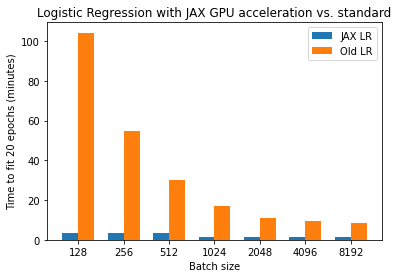

In [ ]:
ind = np.arange(len(times_jax)) 

width = 0.35       
plt.bar(ind, times_jax, width, label='JAX LR')
plt.bar(ind + width, times_old, width,
    label='Old LR')

plt.ylabel('Time to fit 20 epochs (minutes)')
plt.title('Logistic Regression with JAX GPU acceleration vs. standard')
plt.xlabel('Batch size')
plt.xticks(ind + width / 2, batches)
plt.legend(loc='best')
plt.show()

In [ ]:
# They are almost equally accurate
print(lg_sgd_old.score(X_test,y_test))
print(lg_sgd_jax.score(X_test,y_test))

0.49298259267906713
0.49267128
